In [ ]:
# first cell imports all the necessary packages, functions, and classes
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from analysis_classes import *
from analysis_funcs_and_consts import *

#set font to arial
plt.rcParams['font.family'] = 'Arial'
FR_vec_color = '0.9'
FR_vec_width = 1.5




In [ ]:
#get a dictionary with all cells as Cell objects
db_Analysis = DB_Analysis()
db_conditions = {(True, STRAIN) :['CKII', 'SST']}
params={}
result = db_Analysis.run_analysis_func('median ISI', db_conditions, Cell.calc_isi, params, all=False, save=False)

In [ ]:
results_dir = r'Z:\Adam-Lab-Shared\FromExperimentToAnalysis\Rotem\data_analysis\result_dictionaries'
remapping_dir = f'{results_dir}/remapping'

# Load remapping data
with open(f'{remapping_dir}/FR_mats.pkl', 'rb') as f:
    FR_matrices_remap = pickle.load(f)
with open(f'{remapping_dir}/is_PC_dicts.pkl', 'rb') as f:
    is_PC_dicts_remap = pickle.load(f)

# Load regular data
with open(f'{results_dir}/FR_mats.pkl', 'rb') as f:
    FR_matrices_reg = pickle.load(f)
with open(f'{results_dir}/is_PC.pkl', 'rb') as f:
    is_PC_dicts_reg = pickle.load(f)

# Fig 7 - Remapping A

In [ ]:
## functions - move to class if all works well

def is_speed_tuned_on_cell(cell):
    if cell.remapping==True:
        nov_df,fam_df=cell.get_fam_and_novel_df()
        is_tuned_F=is_speed_tuned_on_df(cell,df=fam_df)
        is_tuned_N=is_speed_tuned_on_df(cell,df=nov_df)
        return [is_tuned_F,is_tuned_N]    
    else:
        is_tuned=is_speed_tuned_on_df(cell)
        return [is_tuned]   



def is_speed_tuned_on_df(cell,p_val_threshold=0.01,df=None):
    #using 100ms time bin (frame rate is cell.metadata['frame_rate']), calculate the firing rate in each bin
    if df is None:
        df=cell.exp.data
    # df=df[(~df['position'].between(107,128))] #removing RZ bins
    df=df[df['speed']>=20]
    spikes_col="spikes_cell_"+str(cell.cell_num)
    spike_times=cell.spikes
    #bin the data into 100ms bins
    df=df.reset_index(drop=True)
    df['time']=df['TS_time']-df['TS_time'][0]
    df['binned_time']=pd.cut(df['time'],bins=round(len(df)/cell.metadata['frame_rate']),labels=False)
    #count the number of spikes in each bin
    df['spikes_per_bin']=df.groupby('binned_time')[spikes_col].transform('sum')
    df['speed_per_bin']=df.groupby('binned_time')['speed'].transform('mean')
    #bin the speed per bin into 5 bins
    df['binned_speed']=pd.cut(df['speed_per_bin'],bins=20,labels=False)
    #count the number of spikes in each bin
    spikes_per_bin=df.groupby('binned_speed')['spikes_per_bin'].sum()
    #count the number of frames in each bin
    frames_per_bin=df.groupby('binned_speed')['spikes_per_bin'].count()
    #take into account only bins with more than 1% of the frames
    spikes_per_bin=spikes_per_bin[frames_per_bin>0.01*len(df)]
    frames_per_bin=frames_per_bin[frames_per_bin>0.01*len(df)]
    #divide to get the firing rate in each bin
    FR_per_bin=(spikes_per_bin/frames_per_bin)
    # FR_per_bin=smooth(FR_per_bin,3)
    #turn ndarray to pandas series
    FR_per_bin=pd.Series(FR_per_bin,index=spikes_per_bin.index)
    slope, intercept, r_value, p_value, std_err = stats.linregress(FR_per_bin.index,FR_per_bin)
    if p_value<p_val_threshold:
        return True
    else:
        return False

## Single cell examples

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_single_cell_heatmap_remap(cell,part='first_half',save=False, with_colorbar=False,max_val=None):
    FR_mat = FR_mats_with_halves_all_cells[cell.strain][cell.name][part]
    FR_vec=np.mean(FR_mat,axis=0)
    FR_vec = smooth(FR_vec,3)
    if max_val == None:
        max_val=np.round(np.max(FR_vec),1)
    figsize_mm = (16, 16)
    if with_colorbar:
        # Add extra space for the colorbar, e.g., 5mm
        additional_width_mm = figsize_mm[0] * (0.335) # 20 * 0.15 = 3mm 0.05 is for the colorbar, 0.1 is for the padding
        figsize_mm = (figsize_mm[0] + additional_width_mm, figsize_mm[1])
    figsize_inch = (figsize_mm[0] / 25.4, figsize_mm[1] / 25.4)
    fig, ax = plt.subplots(figsize=figsize_inch)

    img = ax.imshow(FR_mat, aspect='auto', cmap='viridis')
    yticks_labels = [FR_mat.shape[0]]
    plt.yticks([FR_mat.shape[0] - 1], yticks_labels, fontsize=SVG_TICKS)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_tick_params(width=0,pad=0)

    ax2 = ax.twinx()
    ax2.plot(FR_vec, color='#e6e6e6', linewidth=1)
    # ax2.plot(FR_vec, color='0.9', linewidth=1.5)
    ax2.set_ylim(0, max_val)
    # yticks_labels = [int(round(max_val,1))]
    # ax2.set_yticks([round(max_val,1)], yticks_labels, color='k', fontsize=SVG_TICKS)
    ax2.set_yticks([])
    if cell.name == 'SRK1_X_39_1':
        xticks_labels = [0, 160]
        ax.set_xticks([0, 47], xticks_labels, fontsize=SVG_TICKS)
    else:
        ax.set_xticks([])

    # plt.ylabel('Avg. FR (Hz)', fontsize=SVG_LABELS, color='k', rotation=270, labelpad=5)
    #remove top and right spines
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.yaxis.set_tick_params(width=0,pad=0)
    img.set_clim(0, max_val*2) #used to be 0, max_val*1.5
    # make background transparent
    fig.patch.set_alpha(0)
    if with_colorbar:
        cbar = fig.colorbar(img, ax=ax, orientation='vertical', pad=0.1, aspect=15)#, shrink=0.5)
        cbar.set_ticks([0, max_val*2])
        cbar.set_ticklabels([0, max_val*2])
        cbar.ax.tick_params(labelsize=SVG_TICKS)
        cbar.outline.set_visible(False)
        cbar.ax.yaxis.set_tick_params(width=0,pad=0)
    if save:
        plt.savefig(r"\\ems.elsc.huji.ac.il\adam-lab\Adam-Lab-Shared\Presentations\Rotem\PPT slides of data by subjects\vectorized_figures\4-Remapping\Panels\Example heatmaps/"+cell.name+"_FR_mat_viridis_"+part+".svg",format='svg',bbox_inches='tight',dpi=300)

    plt.show()

def plot_cell_pair_heatmap_remap(cell, save=False, with_colorbar=False):
    FR_mat1 = FR_mats_with_halves_all_cells[cell.strain][cell.name]['first_half']
    FR_mat2 = FR_mats_with_halves_all_cells[cell.strain][cell.name]['second_half']
    FR_vec1 = np.mean(FR_mat1, axis=0)
    FR_vec2 = np.mean(FR_mat2, axis=0)
    FR_vec1 = smooth(FR_vec1, 3)
    FR_vec2 = smooth(FR_vec2, 3)
    max_val = np.round(np.max([FR_vec1, FR_vec2]), 1)
    plot_single_cell_heatmap_remap(cell, part='first_half', save=save, with_colorbar=False, max_val=max_val)
    plot_single_cell_heatmap_remap(cell, part='second_half', save=save, with_colorbar=with_colorbar, max_val=max_val)

RCK10_R1_22_8


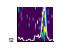

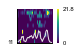

CRK8_R1_22_4


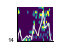

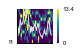

SRK1_R1_66_2


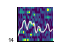

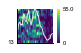

SRK1_R1_66_3


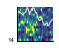

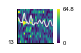

RCK5_L1_61_2


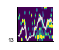

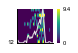

In [ ]:
example_names = ['RCK5_L1_61_2', 'CRK8_R1_22_4', 'RCK10_R1_22_8', 'SRK1_R1_66_2', 'SRK1_R1_66_3']
remap_cells_lst = [cell for cell in result.keys() if cell.name in example_names]
for cell in remap_cells_lst:
    print(cell.name)
    plot_cell_pair_heatmap_remap(cell, save=False, with_colorbar=True)


## Sorted Heatmaps

In [ ]:
remap_cells = [cell for cell in result.keys() if cell.remapping==True and cell.session_num==0]
reg_cells = [cell for cell in result.keys() if cell.remapping==False and cell.session_num==0]

In [ ]:
#split the strains for different criteria in each strain
len_vec=48
CKII_reg1=np.zeros(len_vec);CKII_reg2=np.zeros(len_vec)
CKII_fam=np.zeros(len_vec);CKII_nov=np.zeros(len_vec)
SST_reg1=np.zeros(len_vec);SST_reg2=np.zeros(len_vec)
SST_fam=np.zeros(len_vec);SST_nov=np.zeros(len_vec)

#remaps
for cell in remap_cells:
    if cell.name == 'CRK8_R1_23_4': #problematic cell
        continue
    # if is_PC_dicts_remap[cell.strain][cell.name]['fam']==False or is_PC_dicts_remap[cell.strain][cell.name]['nov']==False: # for untuned cells
    if is_PC_dicts_remap[cell.strain][cell.name]['fam']==True:
            if np.ndim(FR_matrices_remap[cell.strain][cell.name]['fam'])==2 and np.ndim(FR_matrices_remap[cell.strain][cell.name]['nov'])==2:
                FR_mat_fam = FR_matrices_remap[cell.strain][cell.name]['fam']
                FR_mat_nov = FR_matrices_remap[cell.strain][cell.name]['nov']
            FR_vec_fam=np.mean(FR_mat_fam,axis=0)
            FR_vec_fam=smooth(FR_vec_fam,3)
            FR_vec_nov=np.mean(FR_mat_nov,axis=0)
            FR_vec_nov=smooth(FR_vec_nov,3)
            if cell.strain =="CKII":
                CKII_fam = np.vstack((CKII_fam,FR_vec_fam))
                CKII_nov = np.vstack((CKII_nov,FR_vec_nov))
            else:
                SST_fam = np.vstack((SST_fam,FR_vec_fam))
                SST_nov = np.vstack((SST_nov,FR_vec_nov))

#regs
for cell in reg_cells:
    if cell.name == 'RCK2_X_64_cut_laser_drop_2': #problematic cell
        continue
    # if is_PC_dicts_reg[cell.strain][cell.name]==False: # for untuned cells
    if is_PC_dicts_reg[cell.strain][cell.name]==True:
            FR_mat = FR_matrices_reg[cell.strain][cell.name]
            FR_vec_1=np.mean(FR_mat[:int(len(FR_mat)/2)],axis=0)
            FR_vec_1=smooth(FR_vec_1,3)
            FR_vec_2=np.mean(FR_mat[int(len(FR_mat)/2):],axis=0)
            FR_vec_2=smooth(FR_vec_2,3)
            if cell.strain =="CKII":
                CKII_reg1 = np.vstack((CKII_reg1,FR_vec_1))
                CKII_reg2 = np.vstack((CKII_reg2,FR_vec_2))
            else:
                SST_reg1 = np.vstack((SST_reg1,FR_vec_1))
                SST_reg2 = np.vstack((SST_reg2,FR_vec_2))






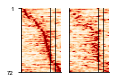

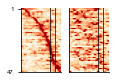

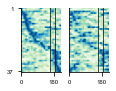

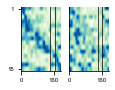

In [ ]:
# SVG format
for strain in ['CKII','SST']:
    if strain=='CKII':
        spine_color=PYR_COLOR
        cmap = 'OrRd'
        mat_to_plot_reg1=CKII_reg1 ; mat_to_plot_reg2=CKII_reg2 ; mat_to_plot_fam=CKII_fam ; mat_to_plot_nov=CKII_nov
    else:
        spine_color=IN_COLOR
        cmap = 'GnBu'
        mat_to_plot_reg1=SST_reg1 ; mat_to_plot_reg2=SST_reg2 ; mat_to_plot_fam=SST_fam ; mat_to_plot_nov=SST_nov

    norm_mat_to_plot_reg1=np.array([normalize(FR_vec) for FR_vec in mat_to_plot_reg1[1:]])
    norm_mat_to_plot_reg2=np.array([normalize(FR_vec) for FR_vec in mat_to_plot_reg2[1:]])
    norm_mat_to_plot_fam=np.array([normalize(FR_vec) for FR_vec in mat_to_plot_fam[1:]])
    norm_mat_to_plot_nov=np.array([normalize(FR_vec) for FR_vec in mat_to_plot_nov[1:]])

    #if a row is NaN, replace it with zeros
    norm_mat_to_plot_reg1[np.isnan(norm_mat_to_plot_reg1)]=0 ; norm_mat_to_plot_reg2[np.isnan(norm_mat_to_plot_reg2)]=0; norm_mat_to_plot_fam[np.isnan(norm_mat_to_plot_fam)]=0; norm_mat_to_plot_nov[np.isnan(norm_mat_to_plot_nov)]=0; 

    sorted_norm_array_reg1,sorted_indices_reg1 = sort_rows_by_max_index(norm_mat_to_plot_reg1)
    sorted_norm_array_reg2=norm_mat_to_plot_reg2[sorted_indices_reg1]
    sorted_norm_array_fam,sorted_indices_fam = sort_rows_by_max_index(norm_mat_to_plot_fam)
    sorted_norm_array_nov=norm_mat_to_plot_nov[sorted_indices_fam]



    #plot as two subplots 
    # figsize_mm = (58,40) - original size
    figsize_mm = (40,30)
    figsize_inch = (figsize_mm[0]/25.4, figsize_mm[1]/25.4)
    fig,ax=plt.subplots(1,2,figsize=figsize_inch)
    ax[0].imshow(sorted_norm_array_reg1,aspect='auto',cmap=cmap)
    ax[0].set_yticks([0,(len(sorted_norm_array_reg1))-1],[1,len(sorted_norm_array_reg1)],fontsize=SVG_TICKS)
    if strain=='SST':
        ax[0].set_xticks([0,39],[0,160],fontsize=SVG_TICKS)
    else:
        ax[0].set_xticks([])
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].axvline(x=35, color='k',alpha=0.7,linewidth=1)
    ax[0].axvline(x=40, color='k',alpha=0.7,linewidth=1)

    ax[1].imshow(sorted_norm_array_reg2,aspect='auto',cmap=cmap)
    ax[1].set_yticks([])
    if strain=='SST':
        ax[1].set_xticks([0,39],[0,160],fontsize=SVG_TICKS)
    else:
        ax[1].set_xticks([])
    #remove top and right spines
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].axvline(x=35, color='k',alpha=0.7,linewidth=1)
    ax[1].axvline(x=40, color='k',alpha=0.7,linewidth=1)
    #remove background color
    fig.patch.set_alpha(0)
    #add spacing between the two subplots
    plt.subplots_adjust(wspace=0.2)
    plt.show()

    figsize_inch = (figsize_mm[0]/25.4, figsize_mm[1]/25.4)
    fig,ax=plt.subplots(1,2,figsize=figsize_inch)
    ax[0].imshow(sorted_norm_array_fam,aspect='auto',cmap=cmap)
    # ax[0].set_ylabel('Cell #',fontsize=20)
    ax[0].set_yticks([0,(len(sorted_norm_array_fam))-1],[1,len(sorted_norm_array_fam)],fontsize=SVG_TICKS)
    if strain=='SST':
        ax[0].set_xticks([0,39],[0,160],fontsize=SVG_TICKS)
    else:
        ax[0].set_xticks([])

    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].axvline(x=35, color='k',alpha=0.7,linewidth=1)
    ax[0].axvline(x=40, color='k',alpha=0.7,linewidth=1)

    ax[1].imshow(sorted_norm_array_nov,aspect='auto',cmap=cmap)
    ax[1].set_yticks([])
    if strain=='SST':
        ax[1].set_xticks([0,39],[0,160],fontsize=SVG_TICKS)
    else:
        ax[1].set_xticks([])

    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].axvline(x=35, color='k',alpha=0.7,linewidth=1)
    ax[1].axvline(x=40, color='k',alpha=0.7,linewidth=1)
    #remove background color
    fig.patch.set_alpha(0)
    #add spacing between the two subplots
    plt.subplots_adjust(wspace=0.2)
    plt.show()

    







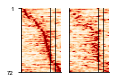

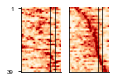

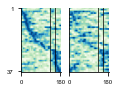

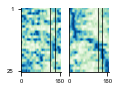

In [ ]:
# SVG format
for strain in ['CKII','SST']:
    if strain=='CKII':
        spine_color=PYR_COLOR
        cmap = 'OrRd'
        mat_to_plot_reg1=CKII_reg1 ; mat_to_plot_reg2=CKII_reg2 ; mat_to_plot_fam=CKII_nov_nov_tuned ; mat_to_plot_nov=CKII_fam_nov_tuned
    else:
        spine_color=IN_COLOR
        cmap = 'GnBu'
        mat_to_plot_reg1=SST_reg1 ; mat_to_plot_reg2=SST_reg2 ; mat_to_plot_fam=SST_nov_nov_tuned ; mat_to_plot_nov=SST_fam_nov_tuned

    norm_mat_to_plot_reg1=np.array([normalize(FR_vec) for FR_vec in mat_to_plot_reg1[1:]]) #remove empty first row
    norm_mat_to_plot_reg2=np.array([normalize(FR_vec) for FR_vec in mat_to_plot_reg2[1:]])
    norm_mat_to_plot_fam=np.array([normalize(FR_vec) for FR_vec in mat_to_plot_fam[1:]])
    norm_mat_to_plot_nov=np.array([normalize(FR_vec) for FR_vec in mat_to_plot_nov[1:]])

    #if a row is NaN, replace it with zeros
    norm_mat_to_plot_reg1[np.isnan(norm_mat_to_plot_reg1)]=0 ; norm_mat_to_plot_reg2[np.isnan(norm_mat_to_plot_reg2)]=0
    norm_mat_to_plot_fam[np.isnan(norm_mat_to_plot_fam)]=0; norm_mat_to_plot_nov[np.isnan(norm_mat_to_plot_nov)]=0
    sorted_norm_array_reg1,sorted_indices_reg1 = sort_rows_by_max_index(norm_mat_to_plot_reg1)
    sorted_norm_array_reg2=norm_mat_to_plot_reg2[sorted_indices_reg1]
    sorted_norm_array_fam,sorted_indices_fam = sort_rows_by_max_index(norm_mat_to_plot_fam)
    sorted_norm_array_nov=norm_mat_to_plot_nov[sorted_indices_fam]

    #plot as two subplots 

    # figsize_mm = (58,40) - original size
    figsize_mm = (40,30)
    figsize_inch = (figsize_mm[0]/25.4, figsize_mm[1]/25.4)
    fig,ax=plt.subplots(1,2,figsize=figsize_inch)
    ax[0].imshow(sorted_norm_array_reg1,aspect='auto',cmap=cmap)
    ax[0].set_yticks([0,(len(sorted_norm_array_reg1))-1],[1,len(sorted_norm_array_reg1)],fontsize=SVG_TICKS)
    if strain=='SST':
        ax[0].set_xticks([0,47],[0,160],fontsize=SVG_TICKS)
    else:
        ax[0].set_xticks([])

    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].axvline(x=35, color='k',alpha=0.7,linewidth=1)
    ax[0].axvline(x=40, color='k',alpha=0.7,linewidth=1)

    ax[1].imshow(sorted_norm_array_reg2,aspect='auto',cmap=cmap)
    ax[1].set_yticks([])
    if strain=='SST':
        ax[1].set_xticks([0,46],[0,160],fontsize=SVG_TICKS)
    else:
        ax[1].set_xticks([])

    #remove top and right spines
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].axvline(x=35, color='k',alpha=0.7,linewidth=1)
    ax[1].axvline(x=40, color='k',alpha=0.7,linewidth=1)
    #remove background color
    fig.patch.set_alpha(0)
    #add spacing between the two subplots
    plt.subplots_adjust(wspace=0.2)
    plt.show()

    figsize_inch = (figsize_mm[0]/25.4, figsize_mm[1]/25.4)
    fig,ax=plt.subplots(1,2,figsize=figsize_inch)
    ax[0].imshow(sorted_norm_array_nov,aspect='auto',cmap=cmap)
    # ax[0].set_ylabel('Cell #',fontsize=20)
    ax[0].set_yticks([0,(len(sorted_norm_array_nov))-1],[1,len(sorted_norm_array_nov)],fontsize=SVG_TICKS)
    if strain=='SST':
        ax[0].set_xticks([0,46],[0,160],fontsize=SVG_TICKS)
    else:
        ax[0].set_xticks([])

    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].axvline(x=35, color='k',alpha=0.7,linewidth=1)
    ax[0].axvline(x=40, color='k',alpha=0.7,linewidth=1)

    ax[1].imshow(sorted_norm_array_fam,aspect='auto',cmap=cmap)
    ax[1].set_yticks([])
    if strain=='SST':
        ax[1].set_xticks([0,46],[0,160],fontsize=SVG_TICKS)
    else:
        ax[1].set_xticks([])

    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].axvline(x=35, color='k',alpha=0.7,linewidth=1)
    ax[1].axvline(x=40, color='k',alpha=0.7,linewidth=1)

    #remove background color
    fig.patch.set_alpha(0)

   
    #add spacing between the two subplots
    plt.subplots_adjust(wspace=0.2)
    plt.show()

    
    if strain=='CKII':
        CKII_sorterd_norm_array_reg1=sorted_norm_array_reg1
        CKII_sorterd_norm_array_reg2=sorted_norm_array_reg2
        CKII_sorterd_norm_array_fam=sorted_norm_array_fam
        CKII_sorterd_norm_array_nov=sorted_norm_array_nov

    else:
        SST_sorterd_norm_array_reg1=sorted_norm_array_reg1
        SST_sorterd_norm_array_reg2=sorted_norm_array_reg2
        SST_sorterd_norm_array_fam=sorted_norm_array_fam
        SST_sorterd_norm_array_nov=sorted_norm_array_nov






### Auto spatail correlation

In [ ]:
#find the correlation between each two rows of the matrix
CKII_reg1_arr=np.array(CKII_reg1[1:]);CKII_reg2_arr=np.array(CKII_reg2[1:]);CKII_fam_arr=np.array(CKII_fam[1:]);CKII_nov_arr=np.array(CKII_nov[1:])
SST_reg1_arr=np.array(SST_reg1[1:]);SST_reg2_arr=np.array(SST_reg2[1:]);SST_fam_arr=np.array(SST_fam[1:]);SST_nov_arr=np.array(SST_nov[1:])

CKII_reg1_reg2=[np.corrcoef(CKII_reg1_arr[i],CKII_reg2_arr[i])[0,1] for i in np.arange(CKII_reg1_arr.shape[0])]
CKII_fam_nov=[np.corrcoef(CKII_fam_arr[i],CKII_nov_arr[i])[0,1] for i in np.arange(CKII_fam_arr.shape[0])]
SST_reg1_reg2=[np.corrcoef(SST_reg1_arr[i],SST_reg2_arr[i])[0,1] for i in np.arange(SST_reg1_arr.shape[0])]
SST_fam_nov=[np.corrcoef(SST_fam_arr[i],SST_nov_arr[i])[0,1] for i in np.arange(SST_fam_arr.shape[0])]

             

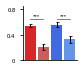

Ttest_indResult(statistic=6.721735713670524, pvalue=6.905677543403266e-10)
Ttest_indResult(statistic=3.6279152861328963, pvalue=0.0006703037225330963)
ShapiroResult(statistic=0.977882981300354, pvalue=0.23522189259529114)
ShapiroResult(statistic=0.954200029373169, pvalue=0.0633586198091507)
ShapiroResult(statistic=0.9531617164611816, pvalue=0.12202391028404236)
ShapiroResult(statistic=0.9646981954574585, pvalue=0.7733026742935181)


In [ ]:
# SVG format
figsize_mm = (25,25)
figsize_inch = (figsize_mm[0]/25.4, figsize_mm[1]/25.4)
plt.figure(figsize=figsize_inch)
plt.bar([0,1,2,3],[np.nanmean(CKII_reg1_reg2),np.nanmean(CKII_fam_nov),np.nanmean(SST_reg1_reg2),np.nanmean(SST_fam_nov)],color=[PYR_COLOR,'indianred',IN_COLOR,'cornflowerblue'],yerr=[stats.sem(CKII_reg1_reg2,nan_policy='omit'),stats.sem(CKII_fam_nov,nan_policy='omit'),stats.sem(SST_reg1_reg2,nan_policy='omit'),stats.sem(SST_fam_nov,nan_policy='omit')],error_kw=dict(lw=1,capsize=1.5, capthick=0.8))

plt.yticks([0,0.4,0.8],[0,0.4,0.8],fontsize=SVG_TICKS)
plt.xticks([])

#add significance stars
x1, x2, x3, x4= 0, 1, 2, 3
y_max = 0.65
y, h, col = y_max, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y, y, y], lw=0.5, c=col)
plt.text((x1+x2-0.1)*.5, y+0.001, "***", ha='center', va='bottom', color=col, fontsize=SVG_TICKS)

y3=y+0.1
plt.plot([x3,x3,x4,x4], [y, y, y, y], lw=0.5, c=col)
plt.text((x3+x4)*.5, y+0.001, "***", ha='center', va='bottom', color=col, fontsize=SVG_TICKS)
plt.ylim(0,0.85)
#remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.savefig(r"Z:/Adam-Lab-Shared/Presentations/Rotem/PPT slides of data by subjects/vectorized_figures/4-Remapping/Panels/Pop. heatmaps/ASC.svg",dpi=300,format='svg',bbox_inches='tight')
plt.show()

# print p values
print(stats.ttest_ind(CKII_reg1_reg2,CKII_fam_nov,nan_policy='omit'))
print(stats.ttest_ind(SST_reg1_reg2,SST_fam_nov))

# shapiro-wilk test for normality
print(stats.shapiro(CKII_reg1_reg2))
print(stats.shapiro(CKII_fam_nov))

print(stats.shapiro(SST_reg1_reg2))
print(stats.shapiro(SST_fam_nov))






In [ ]:
data_dict = {'CKII regs': CKII_reg1_reg2,
             'CKII fam-nov': CKII_fam_nov,
             'SST regs': SST_reg1_reg2,
             'SST fam-nov': SST_fam_nov}
colors = [PYR_COLOR, 'indianred', IN_COLOR, 'cornflowerblue']

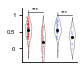

In [ ]:
fig,ax=plot_violin_with_scatter_ver2(
    data_dict, colors,
    figsize_mm=(25, 25), width=0.5, ylim=[-0.4, 1.2],
    linewidth=0.5, jitter=0.03, scatter_size=2, alpha=0.5,
    edgecolor='gray', inner_linewidth=0.5, yticks=[0, 0.5, 1], ylabel=None,
    significance_pairs=[(0,1), (2,3)],
    significance_labels=['***', '***'],
    SVG_TICKS=SVG_TICKS, SVG_LABELS=SVG_LABELS
)



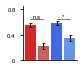

8.210709089406557e-10
0.00017799722073321304
ShapiroResult(statistic=0.9767211675643921, pvalue=0.2023470252752304)
ShapiroResult(statistic=0.9561947584152222, pvalue=0.07599242776632309)
ShapiroResult(statistic=0.9412569999694824, pvalue=0.05057762190699577)
ShapiroResult(statistic=0.9582749605178833, pvalue=0.662446141242981)


In [ ]:
# non-tuned cells - First run the above analysis on nun-tuned cells...
figsize_mm = (25,25)
figsize_inch = (figsize_mm[0]/25.4, figsize_mm[1]/25.4)
plt.figure(figsize=figsize_inch)
plt.bar([0,1,2,3],[np.nanmean(CKII_reg1_reg2),np.nanmean(CKII_fam_nov),np.nanmean(SST_reg1_reg2),np.nanmean(SST_fam_nov)],color=[PYR_COLOR,'indianred',IN_COLOR,'cornflowerblue'],yerr=[stats.sem(CKII_reg1_reg2,nan_policy='omit'),stats.sem(CKII_fam_nov,nan_policy='omit'),stats.sem(SST_reg1_reg2,nan_policy='omit'),stats.sem(SST_fam_nov,nan_policy='omit')],error_kw=dict(lw=1,capsize=1.5, capthick=0.8))

plt.yticks([0,0.4,0.8],[0,0.4,0.8],fontsize=SVG_TICKS)
plt.xticks([])

#add significance stars
x1, x2, x3, x4= 0, 1, 2, 3
y_max = 0.65
y, h, col = y_max, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y, y, y], lw=0.5, c=col)
plt.text((x1+x2-0.1)*.5, y+0.001, "n.s", ha='center', va='bottom', color=col, fontsize=SVG_TICKS)

y3=y+0.1
plt.plot([x3,x3,x4,x4], [y, y, y, y], lw=0.5, c=col)
plt.text((x3+x4)*.5, y+0.001, "*", ha='center', va='bottom', color=col, fontsize=SVG_TICKS)
plt.ylim(0,0.85)
#remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.savefig(r"Z:/Adam-Lab-Shared/Presentations/Rotem/PPT slides of data by subjects/vectorized_figures/4-Remapping/Panels/Pop. heatmaps/ASC_untuned.svg",dpi=300,format='svg',bbox_inches='tight')
plt.show()

# print p values
print(stats.ttest_ind(CKII_reg1_reg2,CKII_fam_nov,nan_policy='omit').pvalue)
print(stats.ttest_ind(SST_reg1_reg2,SST_fam_nov).pvalue)

# shapiro-wilk test for normality
print(stats.shapiro(CKII_reg1_reg2))
print(stats.shapiro(CKII_fam_nov))

print(stats.shapiro(SST_reg1_reg2))
print(stats.shapiro(SST_fam_nov))






## Prop. of place cells

#### Proportion of tuned cells in each half for each condition

In [ ]:
reg_cells = [cell for cell in result.keys() if cell.remapping == False and cell.session_num == 0]
remap_cells = [cell for cell in result.keys() if cell.remapping == True and cell.session_num == 0 and cell.calc_trial_num_within_same_day() <=5]

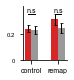

Strain: CKII
Proportion of place cells in reg1 vs reg2: reg1=0.24, reg2=0.23, p=0.8254028702971065
Proportion of place cells in fam vs nov: fam=0.32, nov=0.25, p=0.21351570557105382


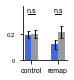

Strain: SST
Proportion of place cells in reg1 vs reg2: reg1=0.2, reg2=0.2, p=0.8972448026405802
Proportion of place cells in fam vs nov: fam=0.12, nov=0.22, p=0.09687189402411288


In [ ]:
figsize_mm = (20, 25)
figsize_inch = (figsize_mm[0] / 25.4, figsize_mm[1] / 25.4)

for strain in ["CKII", "SST"]:
    num_PCs_fam = 0; num_PCs_nov = 0
    num_PCs_reg1 = 0; num_PCs_reg2 = 0
    remap_cells_strain = [cell for cell in remap_cells if cell.strain == strain]
    reg_cells_strain = [cell for cell in reg_cells if cell.strain == strain]
    for cell in remap_cells_strain:
        if is_PC_with_halves_all_cells[cell.strain][cell.name]['first_half']:
            num_PCs_fam += 1
        if is_PC_with_halves_all_cells[cell.strain][cell.name]['second_half']:
            num_PCs_nov += 1
    for cell in reg_cells_strain:
        if is_PC_with_halves_all_cells[cell.strain][cell.name]['first_half']:
            num_PCs_reg1 += 1
        if is_PC_with_halves_all_cells[cell.strain][cell.name]['second_half']:
            num_PCs_reg2 += 1

    plt.figure(figsize=figsize_inch)
    barWidth = 0.25
    
    # Swap control and remap order: Control first (reg), Remap second
    bars_fam = [num_PCs_reg1/len(reg_cells_strain), num_PCs_fam/len(remap_cells_strain)]
    bars_nov = [num_PCs_reg2/len(reg_cells_strain), num_PCs_nov/len(remap_cells_strain)]
    r1 = np.arange(len(bars_fam))
    r2 = [x + barWidth for x in r1]
    
    SE_fam = np.sqrt(bars_fam[0]*(1-bars_fam[0])/len(reg_cells_strain))
    SE_reg1 = np.sqrt(bars_fam[1]*(1-bars_fam[1])/len(remap_cells_strain))
    SE_nov = np.sqrt(bars_nov[0]*(1-bars_nov[0])/len(reg_cells_strain))
    SE_reg2 = np.sqrt(bars_nov[1]*(1-bars_nov[1])/len(remap_cells_strain))
    
    if strain == 'CKII':
        plt.bar(r1, bars_fam, color=PYR_COLOR, width=barWidth, label='1st half', yerr=[SE_fam, SE_reg1], error_kw=dict(lw=1,capsize=1.5, capthick=0.8))
        plt.bar(r2, bars_nov, color='0.6', width=barWidth, label='2nd half', yerr=[SE_nov, SE_reg2], error_kw=dict(lw=1,capsize=1.5, capthick=0.8))
    else:
        plt.bar(r1, bars_fam, color=IN_COLOR, width=barWidth, label='1st half', yerr=[SE_fam, SE_reg1], error_kw=dict(lw=1,capsize=1.5, capthick=0.8))
        plt.bar(r2, bars_nov, color='0.6', width=barWidth, label='2nd half', yerr=[SE_nov, SE_reg2], error_kw=dict(lw=1,capsize=1.5, capthick=0.8))

    # Updated x-axis labels to match swapped order
    plt.xticks([r + barWidth*0.5 for r in range(len(bars_fam))], ['control', 'remap'], fontsize=SVG_LABELS)
    plt.yticks([0, 0.2], [0, 0.2], fontsize=SVG_TICKS)
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ylim = plt.ylim(0, 0.42)
    plt.text(barWidth*0.5, ylim[1]*0.9, 'n.s', fontsize=SVG_LABELS, ha='center')
    plt.text(1 + barWidth*0.5, ylim[1]*0.9, 'n.s', fontsize=SVG_LABELS, ha='center')
    
    plt.plot([0, barWidth], [ylim[1]*0.85, ylim[1]*0.85], color='black', linewidth=1)
    plt.plot([1, 1+barWidth], [ylim[1]*0.85, ylim[1]*0.85], color='black', linewidth=1)
    
    plt.show()
    
    print(f"Strain: {strain}")
    from statsmodels.stats.proportion import proportions_ztest
    
    # Updated stats to match swapped order
    count = np.array([num_PCs_reg1, num_PCs_reg2])
    nobs = np.array([len(reg_cells_strain), len(reg_cells_strain)])
    z, p = proportions_ztest(count, nobs)
    print(f"Proportion of place cells in reg1 vs reg2: reg1={round(num_PCs_reg1/len(reg_cells_strain),2)}, reg2={round(num_PCs_reg2/len(reg_cells_strain),2)}, p={p}")
    
    count = np.array([num_PCs_fam, num_PCs_nov])
    nobs = np.array([len(remap_cells_strain), len(remap_cells_strain)])
    z, p = proportions_ztest(count, nobs)
    print(f"Proportion of place cells in fam vs nov: fam={round(num_PCs_fam/len(remap_cells_strain),2)}, nov={round(num_PCs_nov/len(remap_cells_strain),2)}, p={p}")


## Speed Corr diff violin - remap

In [ ]:
reg_cells = [cell for cell in result.keys() if cell.remapping==False and cell.session_num==0]
remap_cells = [cell for cell in result.keys() if cell.remapping==True and cell.session_num==0 and cell.calc_trial_num_within_same_day()<=5]
SST_reg_cells = [cell for cell in reg_cells if cell.strain == "SST"]
SST_remap_cells = [cell for cell in remap_cells if cell.strain == "SST"]

with open('data_analysis/result_dictionaries/speed_r_vals_with_halves_all_cells.pkl', 'rb') as f:
    speed_r_vals_with_halves_all_cells = pickle.load(f)
with open('data_analysis/result_dictionaries/inst_speed_r_vals_with_halves_all_cells.pkl', 'rb') as f:
    inst_speed_r_vals_with_halves_all_cells = pickle.load(f)

### linear fit r

In [ ]:
strain = "SST"
r_vals_frst_half_reg = []; r_vals_scnd_half_reg = []
r_vals_frst_half_reg_all_cells = []; r_vals_scnd_half_reg_all_cells = []
for cell in SST_reg_cells:
    r_val_frst = speed_r_vals_with_halves_all_cells[cell.strain][cell.name]['first_half']
    r_val_scnd = speed_r_vals_with_halves_all_cells[cell.strain][cell.name]['second_half']
    r_vals_frst_half_reg_all_cells.append(r_val_frst)
    r_vals_scnd_half_reg_all_cells.append(r_val_scnd)
    if is_speed_tuned_with_halves_all_cells[cell.strain][cell.name]['first_half'] == True or \
       is_speed_tuned_with_halves_all_cells[cell.strain][cell.name]['second_half'] == True:
        r_vals_frst_half_reg.append(r_val_frst)
        r_vals_scnd_half_reg.append(r_val_scnd)

r_vals_fam =[]; r_vals_nov = []; r_vals_fam_all_cells = []; r_vals_nov_all_cells = []
for cell in SST_remap_cells:
    r_val_frst = speed_r_vals_with_halves_all_cells[cell.strain][cell.name]['first_half']
    r_val_scnd = speed_r_vals_with_halves_all_cells[cell.strain][cell.name]['second_half']
    r_vals_fam_all_cells.append(r_val_frst)
    r_vals_nov_all_cells.append(r_val_scnd)
    if is_speed_tuned_with_halves_all_cells[cell.strain][cell.name]['first_half'] == True or \
       is_speed_tuned_with_halves_all_cells[cell.strain][cell.name]['second_half'] == True:
        r_vals_fam.append(r_val_frst)
        r_vals_nov.append(r_val_scnd)
        


### inst. r

In [ ]:
strain = "SST"
inst_r_vals_frst_half_reg = []; inst_r_vals_scnd_half_reg = []
inst_r_vals_frst_half_reg_all_cells = []; inst_r_vals_scnd_half_reg_all_cells = []
for cell in SST_reg_cells:
    r_val_frst = inst_speed_r_vals_with_halves_all_cells[cell.strain][cell.name]['first_half']
    r_val_scnd = inst_speed_r_vals_with_halves_all_cells[cell.strain][cell.name]['second_half']
    inst_r_vals_frst_half_reg_all_cells.append(r_val_frst)
    inst_r_vals_scnd_half_reg_all_cells.append(r_val_scnd)
    if is_speed_tuned_with_halves_all_cells[cell.strain][cell.name]['first_half'] == True or \
       is_speed_tuned_with_halves_all_cells[cell.strain][cell.name]['second_half'] == True:
        inst_r_vals_frst_half_reg.append(r_val_frst)
        inst_r_vals_scnd_half_reg.append(r_val_scnd)

inst_r_vals_fam =[]; inst_r_vals_nov = []
inst_r_vals_fam_all_cells = []; inst_r_vals_nov_all_cells = []
for cell in SST_remap_cells:
    r_val_frst = inst_speed_r_vals_with_halves_all_cells[cell.strain][cell.name]['first_half']
    r_val_scnd = inst_speed_r_vals_with_halves_all_cells[cell.strain][cell.name]['second_half']
    inst_r_vals_fam_all_cells.append(r_val_frst)
    inst_r_vals_nov_all_cells.append(r_val_scnd)
    if is_speed_tuned_with_halves_all_cells[cell.strain][cell.name]['first_half'] == True or \
       is_speed_tuned_with_halves_all_cells[cell.strain][cell.name]['second_half'] == True:
        inst_r_vals_fam.append(r_val_frst)
        inst_r_vals_nov.append(r_val_scnd)
        


In [ ]:
def generate_n_shuffled_means_on_array_diffs(array1, array2, n_shuffles=10000):
    """
    Generate n shuffled means on the differences between two arrays.
    """
    diffs = np.abs(array1 - array2)
    observed_mean = np.mean(diffs)
    shuffled_means = []
    for _ in range(n_shuffles):
        shuffled_array1 = np.random.permutation(array1)
        shuffled_mean = np.mean(np.abs(shuffled_array1 - array2))
        shuffled_means.append(shuffled_mean)
    shuffled_means = np.array(shuffled_means)
    p_value = (np.sum(shuffled_means <= observed_mean) + 1) / (n_shuffles + 1)
    return diffs,observed_mean, shuffled_means, p_value

# Define datasets
datasets = [
    ('Reg ST', r_vals_frst_half_reg, r_vals_scnd_half_reg),
    ('Remap ST', r_vals_fam, r_vals_nov),
    ('Reg (inst) ST', inst_r_vals_frst_half_reg, inst_r_vals_scnd_half_reg),
    ('Remap (inst) ST', inst_r_vals_fam, inst_r_vals_nov),

]

datasets_all_cells = [
    ('Reg ST (all cells)', r_vals_frst_half_reg_all_cells, r_vals_scnd_half_reg_all_cells),
    ('Remap ST (all cells)', r_vals_fam_all_cells, r_vals_nov_all_cells),
    ('Reg (inst) ST (all cells)', inst_r_vals_frst_half_reg_all_cells, inst_r_vals_scnd_half_reg_all_cells),
    ('Remap (inst) ST (all cells)', inst_r_vals_fam_all_cells, inst_r_vals_nov_all_cells),
]

# Combine all datasets
all_datasets = datasets + datasets_all_cells

# Initialize result storage
results = {}

# Loop and compute
for name, arr1, arr2 in all_datasets:
    diffs,observed_mean, shuffled_means, p_value = generate_n_shuffled_means_on_array_diffs(np.array(arr1), np.array(arr2))
    results[name] = {
        'diffs': diffs,
        'observed_mean': observed_mean,
        'shuffled_means': shuffled_means,
        'p_value': p_value
    }
    print(f"{name}:")
    print(f"  p-value: {p_value:.4f}\n")

Reg ST:
  p-value: 0.3753

Remap ST:
  p-value: 0.3079

Reg (inst) ST:
  p-value: 0.0001

Remap (inst) ST:
  p-value: 0.0156

Reg ST (all cells):
  p-value: 0.0001

Remap ST (all cells):
  p-value: 0.0001

Reg (inst) ST (all cells):
  p-value: 0.0001

Remap (inst) ST (all cells):
  p-value: 0.0001



In [ ]:
def plot_W0_W2_violins_with_histograms(result_dict, shuffled_distributions, cell_name,
                                       palette=[PYR_COLOR, PYR_COLOR_weak],
                                       ylabel=False, yticks=np.arange(-0.5, 1.1, 0.5), ylims=(-0.7, 1.5),
                                       save_path=None, SVG_TICKS=6, SVG_LABELS=6, figsize_mm=(12.5, 25),
                                       rotation =0, title='',offset=0.3, paired=True, key_type='W0W2'):
    from scipy.stats import gaussian_kde, ttest_rel, ttest_ind

    # Determine keys based on key_type
    if key_type == 'W0W2':
        key1, key2 = 'W0_W0', 'W0_W2'
        xtick_labels = ['W0-W0', 'W0-W2']
    elif key_type == 'RegRemap':
        key1, key2 = 'Reg', 'Remap'
        xtick_labels = ['Reg', 'Remap']
    else:
        raise ValueError("key_type must be either 'W0W2' or 'RegRemap'")
    if paired:
        W0_values = [res[key1] for res in result_dict.values()]
        W2_values = [res[key2] for res in result_dict.values()]
    else:
        W0_values = result_dict[key1]
        W2_values = result_dict[key2]
    shuffled_means = [np.mean(dist) for dist in shuffled_distributions]

    # Stats: paired or unpaired
    shapiro_w0 = stats.shapiro(W0_values)[1]
    shapiro_w2 = stats.shapiro(W2_values)[1]
    print(f"Shapiro-W0: {shapiro_w0}, Shapiro-W2: {shapiro_w2}")
    if shapiro_w0 < 0.05 or shapiro_w2 < 0.05:
        print("Data is not normally distributed, using non-parametric test.")
        if paired:
            p = stats.wilcoxon(W0_values, W2_values)[1]
            print(stats.wilcoxon(W0_values, W2_values))
        else:
            p = stats.ranksums(W0_values, W2_values)[1]
        print(stats.ranksums(W0_values, W2_values))
    else:
        if paired:
            p = ttest_rel(W0_values, W2_values)[1]
            print(stats.ttest_rel(W0_values, W2_values))
        else:
            p = ttest_ind(W0_values, W2_values)[1]
            print(stats.ttest_ind(W0_values, W2_values))

    # Setup
    figsize_inch = (figsize_mm[0] / 25.4, figsize_mm[1] / 25.4)
    fig, ax = plt.subplots(figsize=figsize_inch)

    # Violin plots
    sns.violinplot(data=[W0_values, W2_values], color='white', linewidth=0.5, width=0.5,
                   zorder=0, alpha=1, inner=None, ax=ax)
    for collection in ax.collections:
        collection.set_edgecolor('gray')
    for line in ax.lines:
        line.set_color('black')
        line.set_linewidth(0.5)

    # Scatter points with jitter
    jitter_0 = np.random.normal(0, 0.02, size=len(W0_values))
    jitter_1 = np.random.normal(0, 0.02, size=len(W2_values))
    ax.scatter(np.zeros(len(W0_values)) + jitter_0, W0_values, color=palette[0], s=2, alpha=0.8, edgecolors='none')
    ax.scatter(np.ones(len(W2_values)) + jitter_1, W2_values, color=palette[1], s=2, alpha=0.8, edgecolors='none')

    # Connect lines (only if paired)
    if paired:
        for i in range(min(len(W0_values), len(W2_values))):
            ax.plot([0 + jitter_0[i], 1 + jitter_1[i]], [W0_values[i], W2_values[i]],
                    color='gray', alpha=0.5, linewidth=0.5)

    # Mean points
    ax.scatter(0, np.mean(W0_values), color='k', s=2, zorder=2)
    ax.scatter(1, np.mean(W2_values), color='k', s=2, zorder=2)
    
    #print mean and SEM
    mean_w0 = np.mean(W0_values)
    sem_w0 = stats.sem(W0_values)
    mean_w2 = np.mean(W2_values)
    sem_w2 = stats.sem(W2_values)
    print(f"Mean W0: {mean_w0:.3f} ± {sem_w0:.3f}, Mean W2: {mean_w2:.3f} ± {sem_w2:.3f}")
    

    # KDE histograms
    histogram_offset = offset
    for i, (shuffled, x_center) in enumerate(zip(shuffled_distributions, [0, 1])):
        kde = gaussian_kde(shuffled)
        y_vals = np.linspace(min(shuffled), max(shuffled), 300)
        density = kde(y_vals)
        density = density / np.max(density) * 0.2
        ax.plot(x_center + histogram_offset + density, y_vals, color='k', linewidth=0.7, alpha=0.7)
        lower, upper = np.percentile(shuffled, [1, 99])
        ax.plot([x_center + histogram_offset, x_center + histogram_offset + 0.2], [lower, lower],
                color='k', linestyle='--', linewidth=0.6)
        ax.plot([x_center + histogram_offset, x_center + histogram_offset + 0.2], [upper, upper],
                color='k', linestyle='--', linewidth=0.6)
        obs_mean = np.mean(W0_values) if i == 0 else np.mean(W2_values)
        p_val = 2 * min(np.mean(shuffled >= obs_mean), np.mean(shuffled <= obs_mean))
        y_peak = y_vals[np.argmax(density)]
        if p_val > 0.05:
            shuffle_sig = "n.s."
        elif p_val < 0.001:
            shuffle_sig = "***"
        elif p_val < 0.01:
            shuffle_sig = "**"
        else:
            shuffle_sig = "*"
        ax.text(x_center + histogram_offset, y_peak, shuffle_sig, ha='center', va='center',
                fontsize=SVG_TICKS, rotation=90)

    # Y axis
    ax.set_ylim(ylims)
    ax.set_yticks(yticks)
    ax.tick_params(axis='y', labelsize=SVG_TICKS)
    ax.set_xticks([0, 1], xtick_labels, fontsize=SVG_TICKS, rotation=rotation)
    ax.set_title(title, fontsize=SVG_LABELS)

    # Overall significance annotation
    y_lim = ax.get_ylim()
    x_center = 0.5
    if p > 0.05:
        sig_label = "n.s"
    elif p < 0.001:
        sig_label = "***"
    elif p < 0.01:
        sig_label = "**"
    else:
        sig_label = "*"
    ax.text(x_center, y_lim[1] * 0.9, sig_label, ha='center', va='bottom', color='k', fontsize=SVG_TICKS)
    #plot a line below the significance label
    plt.plot([0, 1], [y_lim[1] * 0.85, y_lim[1] * 0.85], color='k', linewidth=0.5)

    if ylabel:
        ax.set_ylabel(ylabel, fontsize=SVG_LABELS)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig.patch.set_facecolor('none')

    if save_path:
        plt.savefig(save_path, dpi=300, format=save_path.split('.')[-1], bbox_inches='tight')

    return fig, ax


Shapiro-W0: 6.218797352630645e-07, Shapiro-W2: 0.0037368431221693754
Data is not normally distributed, using non-parametric test.
RanksumsResult(statistic=-0.8203774460090628, pvalue=0.4120009687998324)
Mean W0: 0.142 ± 0.010, Mean W2: 0.162 ± 0.018


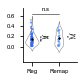

In [ ]:
r_vals_remapping_dict = {
    'Reg': results['Reg ST']['diffs'],
    'Remap': results['Remap ST']['diffs']
}

r_vals_remapping_dict_inst = {
    'Reg': results['Reg (inst) ST']['diffs'],
    'Remap': results['Remap (inst) ST']['diffs']
}
r_vals_remapping_dict_all_cells = {
    'Reg': results['Reg ST (all cells)']['diffs'],
    'Remap': results['Remap ST (all cells)']['diffs']
}

r_vals_remapping_dict_inst_all_cells = {
    'Reg': results['Reg (inst) ST (all cells)']['diffs'],
    'Remap': results['Remap (inst) ST (all cells)']['diffs']
}


plot_W0_W2_violins_with_histograms(r_vals_remapping_dict_inst,[results['Reg (inst) ST']['shuffled_means'],
                            results['Remap (inst) ST']['shuffled_means']], "SST", palette=[IN_COLOR, IN_COLOR_weak], ylabel="",
                            yticks=[0,0.2,0.4,0.6], ylims=(-0.3, 0.75),
                            save_path=False,
                            SVG_TICKS=SVG_TICKS, SVG_LABELS=SVG_LABELS,figsize_mm=(25, 25),offset=0.4,
                            paired=False,key_type='RegRemap',title='')
fig= plt.gcf()